# SNR Grid Calculations Tutorial

In [3]:
# import some general packages
import sys,os
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from matplotlib.colors import LogNorm
from datetime import date

# Load some stuff from specsim
# Run in main folder specsim/
os.chdir('../') # if running in examples/ folder, need to be in main folder
from specsim import objects, load_inputs, functions, plot_tools, obs_tools

## Loading Config File & Running an Observation

### Background
Key parameters are stored in the configuration file "hispec.cfg". The function "load_object" loads the contents of this configuration file into a storage object "so'. The objects.py function is a useful reference for seeing what is contained in so, but it has class attributes like 'stel' for stellar properties and 'track' for tracking camera properties. For example, the stellar temperature defined in the config file will be loaded and stored in "so.stel.teff".

The "fill_data" class takes the storage object and upon initiation, it fills the so object by running a bunch of things. As such, this process takes a little while - first it defines the wavelength grid (x) and yJHK filter bounds, then does the dirty work of loading, reinterpolating files, and calculating things in the following order:

**filter**
    (loads zeropoint and filter transmission curve for the band selected)

**stellar** 
    (loads the stellar spectrum based on the temperature chosen and scales it to the magnitude requested in the filter band set in the filter attribute of so)

**telluric**
    (loads the telluric spectrum and scales to the requested PWV and airmass)

**ao**
    (by default takes the magnitude of the star and uses input files to determine the expected WFE based on the AO mode selected which should match headers in the file. Or one can just set the params to some WFE)

**instrument**
    (loads the instrument transmission file if there is one, otherwise does HISPEC/MODHIS specific things and loads the base throughput and finds the coupling based on the WFE found previously assuming a specific file format)

**observe** 
    (takes all the loaded files to find the spectral flux at the instruments and degrades and resamples the spectrum according to the resolution and pixels provided. It also loads the background spectrum and noise to get the SNR per pixel and per resolution element)

**tracking** 
    (loads the tracking camera properties for the camera specified, loads the transmission file, interpolates, calculates the platescale, makes the tracking band transmission file, computs the PSF FWHM and the strehl, determines the sky and instrument background, computes the photons at the tracking camera, combines the noise, gives the SNR and expected centroid error
    
There are some other functions in the load_objects.py that can be used to reload a subset of things and are useful since there are a lot of orders of operations. These are still kinda confusing but I will demonstrate how I use them to cycle over a lot of parameters

## The Code - Running A Single Instance
Here is the code to load a config file and run it

In [4]:
# configfile = './configs/modhis_snr.cfg' # define our config file name and path
configfile = './specsim/configs/modhis_snr.cfg' # path that works for my version
so    = objects.load_object(configfile)  # Load the contents of the config file into the so "storage object"
cload = load_inputs.fill_data(so)        # Initiate the fill_data class which runs an observation and stores the results in so

Exception: Config File is Not Found!

# Changing a parameter - Method 1
The following example shows how to change the temperature of the star and rerun using the same code. At a different temperature, the magnitude of the star in the band pertinent to defining the AO performance will be different and therefore the AO performance will be different

In [13]:
so.stel.teff = 5800               # redefine the stellar temperature
cload = load_inputs.fill_data(so) # redo filling the data

------FILLING OBJECT--------
Teff set to 5800
K band mag set to 8
AO mode: LGS_ON
HO WFE is 181.0
tt dynamic is 1.4
Nframes set to 11
Texp per frame set to 54.55


Text(0.5, 0, 'Wavelength [nm]')

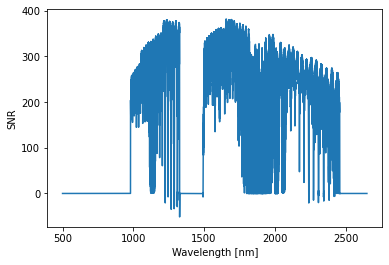

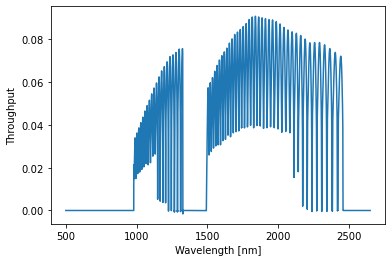

In [4]:
#plot SNR spectrum
plt.figure()
plt.plot(so.obs.v,so.obs.snr)
plt.ylabel('SNR')
plt.xlabel('Wavelength [nm]')

# plot instrument throughput
plt.figure()
plt.plot(so.inst.xtransmit,so.inst.ytransmit)
plt.ylabel('Throughput')
plt.xlabel('Wavelength [nm]')



# Changing a parameter - Method 2
Some parameters or situations don't require re-running everything. For example, maybe you don't care about the tracking camera. Or if we only want to change something related to the tracking camera, we don't need to re-run the spectrograph. In this case we can use some of the extra functions defined in the fill_data class such as 'set_mag'. Here is an example below. Also note that because the star is so bright, the exposure time per frame was set to 54.5 sec to avoid saturation with number of frames at 11. This totals to 600s as requested in the config file.


-----Reloading Stellar Magnitude-----
Teff set to 5800
K band mag set to 8
AO mode: LGS_ON
HO WFE is 181.0
tt dynamic is 1.4
Nframes set to 11
Texp per frame set to 54.55


Text(0.5, 0, 'Wavelength [nm]')

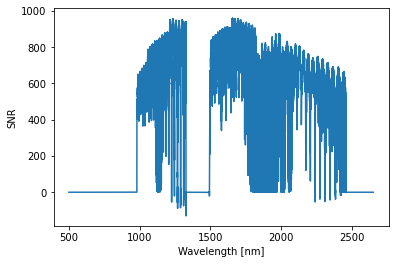

In [5]:
new_mag = 8
cload.set_mag(so, new_mag)

plt.figure()
plt.plot(so.obs.v,so.obs.snr)
plt.ylabel('SNR')
plt.xlabel('Wavelength [nm]')



# Plotting the Spectrum
There are several tools for plotting the spectra nicer in plot_tools.py which we loaded earlier as plot_tools. Not all plot functions are currently working well and a lot require certain data paths to be fixed. 

Here is an example how to use some of the key ones that should work! For example, how to plot the SNR spectrum, the base throughput, the background noise, etc. These functions take the so object, so it plots the parameters stored in so from the latest run.

No handles with labels found to put in legend.


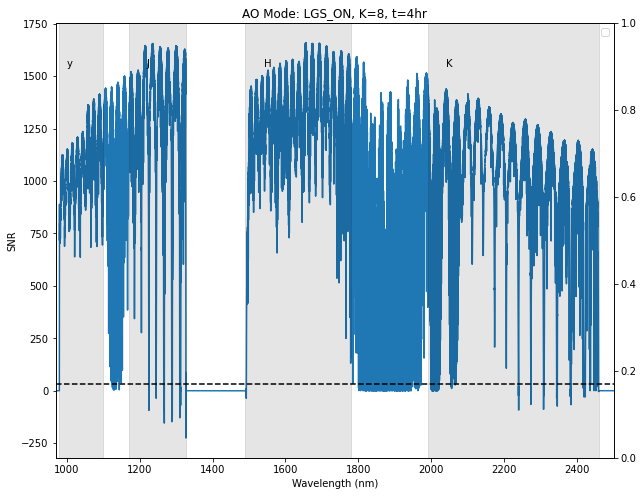

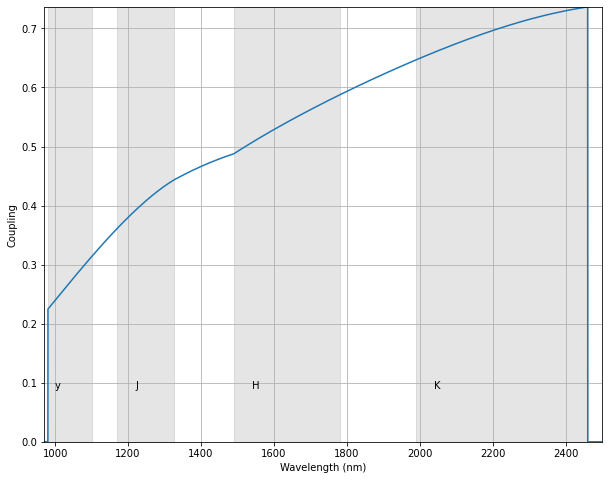

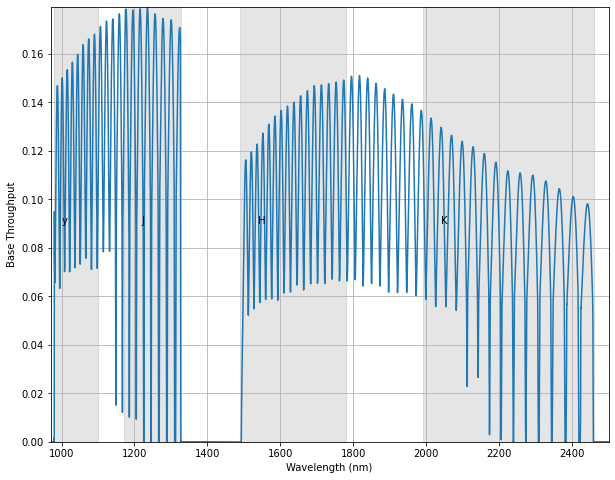

In [6]:
savepath = './examples/output/'
plot_tools.plot_snr(so,snrtype='res_element',savepath=savepath) # snr type is either 'pixel' or 'reselement'
plot_tools.plot_coupling(so,savepath=savepath) # these ones are weird
plot_tools.plot_base_throughput(so,savepath=savepath)


# Running a grid of parameters
First define the functions to compute the grid of SNRs for different stellar magnitudes and to plot them

In [10]:
def run_snr_v_mag(so,teff='default',ao_mode='default'):
    """
    code to step through magnitudes
    """
    if teff!='default':  so.stel.teff = teff
    if ao_mode!='default':  so.ao.mode = ao_mode # load new ao mode

    cload.set_teff_mag(so,so.stel.teff,so.stel.mag,staronly=False)
    mag_arr= np.arange(5,16)
    snr_arr = []
    s_arr   = []
    n_arr   = []
    c_arr   = []
    snr_reselement= []

    for mag in mag_arr:
        cload.set_mag(so,mag) 
        snr_arr.append(so.obs.snr)
        s_arr.append(so.obs.s_frame)
        snr_reselement.append(so.obs.snr_res_element) # plot snr per res element
        n_arr.append(so.obs.noise_frame)
        c_arr.append(so.inst.coupling)

    return mag_arr,snr_arr,s_arr,n_arr,c_arr,snr_reselement

def plot_snr_mag_peaks_2d(so, mag_arr,v,snr_arr,xextent=[980,2460],mode='max'):
    """
    """
    def fmt(x):
        return str(int(x))

    snr_arr_order= []
    for i,mag in enumerate(mag_arr):
        cen_lam, snr_peaks,snr_means = obs_tools.get_order_value(so,v,snr_arr[i])
        if mode=='max':
            #ax.plot(cen_lam,snr_peaks,label='m=%s'%mag)
            snr_arr_order.append(snr_peaks)
        elif mode=='mean':
            #ax.plot(cen_lam,snr_means,label='m=%s'%mag)
            snr_arr_order.append(snr_means)

    snr_arr_order = np.array(snr_arr_order)

    # resample onto regular grid for imshow
    #xs = np.arange(np.min(cen_lam),np.max(cen_lam))
    xs = np.arange(np.min(xextent), np.max(xextent))
    snr_arr_order_regular = np.zeros((len(mag_arr),len(xs)))
    for i,mag in enumerate(mag_arr):
        tmp = interpolate.interp1d(cen_lam, snr_arr_order[i],kind='linear',bounds_error=False,fill_value=0)
        snr_arr_order_regular[i,:] = tmp(xs)

    extent = (np.min(xs),np.max(xs),np.min(mag_arr),np.max(mag_arr))

    fig, ax = plt.subplots(1,1, figsize=(9,8))	
    ax.imshow(snr_arr_order_regular,aspect='auto',origin='lower',\
                interpolation='quadric',cmap='nipy_spectral',\
                extent=extent,vmax=10000,vmin=1,norm=LogNorm())
    cs = ax.contour(snr_arr_order_regular, levels=[30,50,100,200,500,1000] ,\
                colors=['r','k','k','k','k','k'],origin='lower',\
                extent=extent)
    ax.invert_yaxis()
    ax.clabel(cs, cs.levels, inline=True,fmt=fmt,fontsize=10,\
        colors=['r','r','r','r'],zorder=101)
    #plt.xticks(list(cen_lam))
    blackout = [1327,1490]
    plt.fill_between(blackout,np.min(mag_arr),np.max(mag_arr),facecolor='k',\
            hatch='X',edgecolor='gray',zorder=100)
    try:
        c30   = cs.collections[0].get_paths()[1].vertices # extract 30 snr curve
        c30_2 = cs.collections[0].get_paths()[0].vertices # extract 30 snr curve
        plt.fill_between(c30[:,0],np.max(mag_arr),c30[:,1],hatch='/',fc='k',edgecolor='r')
        plt.fill_between(c30_2[:,0],np.max(mag_arr),c30_2[:,1],hatch='/',fc='k',edgecolor='r')
    except IndexError:
        pass

    ax.set_ylabel('%s Magnitude'%so.filt.band)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_xlim(xextent)
    ax.set_title('AO Mode: %s, %sband, Teff:%s, t=4hr'%(so.ao.mode,so.filt.band,so.stel.teff))
    figname = 'snr2d_%s_band_%s_teff_%s_texp_%ss.png' %(so.ao.mode,so.filt.band,so.stel.teff,so.obs.texp)
    # duplicate axis to plot filter response
    plt.savefig('./' + figname)




Teff set to 5800
K band mag set to 15
AO mode: LGS_ON
HO WFE is 181.0
tt dynamic is 1.4
Nframes set to 1
Texp per frame set to 600.0
-----Reloading Stellar Magnitude-----
Teff set to 5800
K band mag set to 5
AO mode: LGS_ON
HO WFE is 181.0
tt dynamic is 1.4
Nframes set to 168
Texp per frame set to 3.57
-----Reloading Stellar Magnitude-----
Teff set to 5800
K band mag set to 6
AO mode: LGS_ON
HO WFE is 181.0
tt dynamic is 1.4
Nframes set to 67
Texp per frame set to 8.96
-----Reloading Stellar Magnitude-----
Teff set to 5800
K band mag set to 7
AO mode: LGS_ON
HO WFE is 181.0
tt dynamic is 1.4
Nframes set to 27
Texp per frame set to 22.22
-----Reloading Stellar Magnitude-----
Teff set to 5800
K band mag set to 8
AO mode: LGS_ON
HO WFE is 181.0
tt dynamic is 1.4
Nframes set to 11
Texp per frame set to 54.55
-----Reloading Stellar Magnitude-----
Teff set to 5800
K band mag set to 9
AO mode: LGS_ON
HO WFE is 181.0
tt dynamic is 1.4
Nframes set to 5
Texp per frame set to 120.0
-----Reloading

/var/folders/1l/ncy95x4d1sd5jspjc2k39x8r0000gn/T/ipykernel_26330/711795417.py:55: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.imshow(snr_arr_order_regular,aspect='auto',origin='lower',\


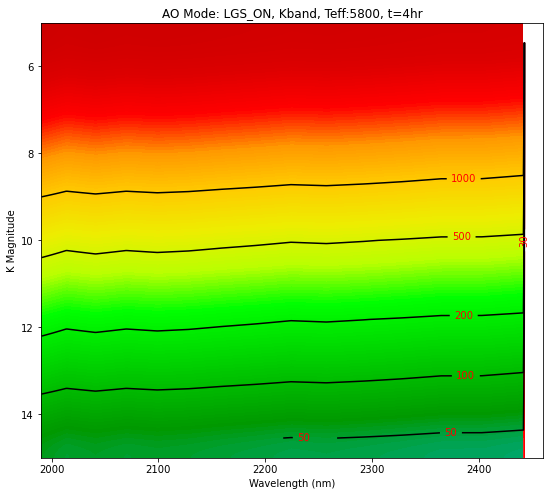

In [15]:
# Run for each filter band
mag_arr,snr_arr,s_arr,n_arr,c_arr,snr_res_element = run_snr_v_mag(so)
plot_snr_mag_peaks_2d(so, mag_arr,so.obs.v_res_element,snr_res_element,xextent=so.inst.K,mode='max')


# Future Implementation List

- add a function that prints key parameters defined in "so" - perhaps be able to print a summary for each item like telluric, stellar, etc. And also a general one

- make plotting scripts work, cut out ones that dont work or work on saved files not included in the utilities (e.g. only save plot scripts that plot things from so object)

- implement variable resolution

- implement testing functions to test things are working properly - one good test is to check the validity of magnitude conversions, like the colors of the given star can be checked

- comment objects.py and add all new variables to init

- make AO mode selection automatic to best mode, filter families combined into filter name